In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
gbest_history=[]
class Particle:
    def __init__(self, dim, minx, maxx):
        self.position = np.random.uniform(minx, maxx, dim)
        self.velocity = np.random.uniform(-1, 1, size=dim)
        self.pbest_position = self.position.copy()
        self.pbest_score = np.inf
        self.score = np.inf
        self.dim=dim
        
    def update_velocity(self, inertia, c1, c2, gbest_position,repulsive_sources, 
                        repulsion_strength=1.0,attraction_scale=1.0, epilson=1e-6):

        r1 = np.random.rand(self.dim)
        r2 = np.random.rand(self.dim)
        r3 = np.random.rand(self.dim)

        dp = self.pbest_position - self.position
        distance_p = np.linalg.norm(dp)
        # 高斯衰减系数
        cognitive_weight = c1 * np.exp(-distance_p** 2 / (2 * attraction_scale**2))
        cognitive = cognitive_weight * r1* dp 

        dg = gbest_position - self.position
        distance_g = np.linalg.norm(dg)
        social_weight = c2 * np.exp(-distance_g**2/ (2 * attraction_scale**2))
        social = social_weight * r2* dg 
        
        repulsion = np.zeros_like(self.velocity)
        for source in repulsive_sources:
            vec = self.position - source
            distance_v = np.linalg.norm(vec)
            if distance_v < epilson:
                continue
            repulsion_strength_scaled =  np.exp(-distance_v** 2 / (2 * attraction_scale**2))
            repulsion += (repulsion_strength_scaled) * r3* (vec)
            
        self.velocity = inertia * self.velocity + cognitive + social + repulsion_strength*repulsion

    def update_position(self, minx, maxx):
        self.position += self.velocity
        self.position = np.clip(self.position, minx, maxx)

    def mutation(self,pm):
        if np.random.rand()<pm:
            theta=1.0/(1.0+np.exp(-self.score))
            self.position+=np.random.normal(0,theta,size=self.position.shape)

def normalize_fitness(fitness_values):
    min_f = min(fitness_values)
    max_f = max(fitness_values)
    # 添加epsilon防止除零（如1e-10）
    epsilon = 1e-10
    return [(f - min_f + epsilon) / (max_f - min_f + epsilon) for f in fitness_values]

def hybridize(parent1, parent2, dim, minx, maxx,pm=0.1):
    alpha = np.random.rand()
    child_pos = alpha * parent1.position + (1-alpha) * parent2.position
    child_vel = alpha * parent1.velocity + (1-alpha) * parent2.velocity
    if np.random.rand() < pm:
        child_pos+=np.random.normal(0,0.5,size=child_pos.shape)
    child = Particle(dim, minx, maxx)

    child.position = child_pos
    child.velocity = child_vel
    return child

def select_parents(remaining,k=2,replace=False):
    scores=np.array([p.score for p in remaining])
    fitness=1.0/(scores+1e-6)
    fitness=normalize_fitness(fitness)
    total_fitness=np.sum(fitness)
    probs=fitness/total_fitness
    parents_indices=np.random.choice(len(remaining),k,replace=replace,p=probs)
    return [remaining[i] for i in parents_indices]



def modified_pso(objective_func, dim, minx, maxx,
                 n_particles=50, n_iterations=200, inertia=0.8,pm=0.1, 
                 c1=1.5, c2=1.5, k_eliminate=2, attraction_scale=1.0):
    particles = [Particle(dim, minx, maxx) for _ in range(n_particles)]
    gbest_position = np.zeros(dim)
    gbest_score = np.inf

    for iteration in range(n_iterations):
        current_inertia = inertia - (inertia - 0.4) * (iteration / n_iterations)
        for p in particles:
            p.score = objective_func(p.position)
            if p.score < p.pbest_score:
                p.pbest_score = p.score
                p.pbest_position = p.position.copy()
            if p.score < gbest_score:
                gbest_score = p.score
                gbest_position = p.position.copy()
        gbest_history.append(gbest_score)
        particles.sort(key=lambda x: x.score, reverse=True)
        eliminated = particles[:k_eliminate]
        remaining = particles[k_eliminate:]

        new_particles = []
        for _ in range(k_eliminate):
            parents = select_parents(remaining, 2, replace=False)
            child = hybridize(parents[0], parents[1], dim, minx, maxx)
            new_particles.append(child)
        
        repulsive_sources = [e.position.copy() for e in eliminated]

        particles = remaining + new_particles
        for p in particles:
            p.update_velocity(current_inertia, c1, c2, gbest_position,
                            repulsive_sources,attraction_scale)
            p.update_position(minx, maxx)
            p.mutation(pm)


    return gbest_position, gbest_score


In [14]:
#测试函数集
def rastrigin(x):
    return 10*len(x) + np.sum(x**2 - 10*np.cos(2*np.pi*x))
def rosenbrock(x):
    return sum(100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x)-1))
def ackley(x):
    a = 20
    b = 0.2
    c = 2 * np.pi
    n = len(x)
    sum1 = np.sum(x**2 )
    sum2 = np.sum(np.cos(c * x))
    return -a * np.exp(-b * np.sqrt(sum1 / n)) - np.exp(sum2 / n) + a + np.exp(1)
def griewank(x):
    sum1 = sum(x[i]**2 / 4000 for i in range(len(x)))
    prod1 = np.prod([np.cos(x[i] / np.sqrt(i+1)) for i in range(len(x))])
    return sum1 - prod1 + 1
def Pressure_Vessel_func(x):
    f=0.6224*x[0]*x[2]*x[3]+1.7781*x[1]*(x[2]**2)+3.1661*x[3]*(x[0]**2)+19.84*x[2]*(x[0]**2)
    return np.abs(f)

Optimized Position: [ 0.01776908  0.01046127 -0.00255092 -0.00549457]
Optimized Score: 0.00019019397753161638


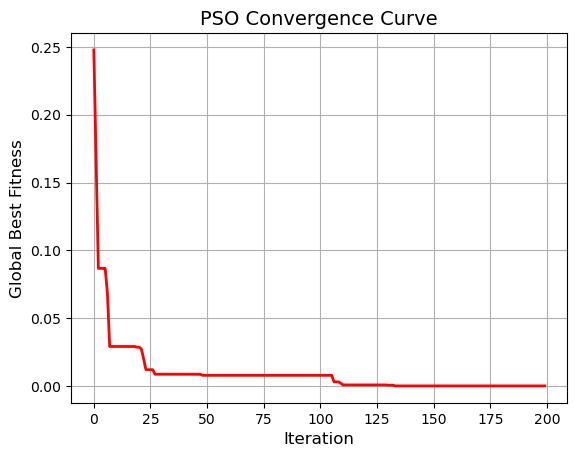

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform,randint
from sklearn.metrics import make_scorer

dim = 4
minx=-5.12
maxx=5.12
n_iterations = 200
n_particles =80
inertia=0.88
c1=1.83
c2=2.15
k_eliminate=4
pm=0.06
    
best_position, best_score = modified_pso(
        griewank , dim, minx, maxx, n_particles, n_iterations,
        inertia,pm,c1,c2,k_eliminate,attraction_scale=2.0  # 可以调整这个参数来控制信息素衰减速度
)
print("Optimized Position:", best_position)
print("Optimized Score:", best_score)
# 绘制收敛曲线
plt.plot(gbest_history, 'r-', linewidth=2)
plt.title('PSO Convergence Curve', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Global Best Fitness', fontsize=12)
plt.grid(True)
plt.show()